In [12]:
from glob import glob
import pandas as pd
import numpy as np
import os

import keras
from keras import layers,models
from keras.preprocessing.sequence import pad_sequences
from keras.layers.core import Activation
from keras import regularizers
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

In [51]:
x=0
for filename in glob("UCRArchive_2018/*"):
    train_name = os.path.join(filename,os.path.basename(filename)+"_TRAIN.tsv")
    test_name = os.path.join(filename,os.path.basename(filename)+"_TEST.tsv")
    if x==0:
        break
    x+=1

In [52]:
df_train=pd.read_table(train_name,header=None)
X_train=df_train.values[:,1:]
y_train=df_train.values[:,0]

df_test=pd.read_table(test_name,header=None)
X_test=df_test.values[:,1:]
y_test=df_test.values[:,0]

y = np.r_[y_train,y_test]
y_encoded = np_utils.to_categorical(y)
y_train_encoded = y_encoded[:len(y_train)]
y_test_encoded = y_encoded[len(y_test):]

ss=StandardScaler()
X_train=ss.fit_transform(X_train)
X_test=ss.transform(X_test)


In [53]:
r=2**4

if not X_train.shape[-1] %r == 0:
    X_train = pad_sequences(X_train,X_train.shape[-1] //r *r+r,dtype=float)
    X_test = pad_sequences(X_test,X_test.shape[-1] //r *r+r,dtype=float)

In [54]:
help(layers.SeparableConv1D)

Help on class SeparableConv1D in module keras.layers.convolutional:

class SeparableConv1D(_SeparableConv)
 |  Depthwise separable 1D convolution.
 |  
 |  Separable convolutions consist in first performing
 |  a depthwise spatial convolution
 |  (which acts on each input channel separately)
 |  followed by a pointwise convolution which mixes together the resulting
 |  output channels. The `depth_multiplier` argument controls how many
 |  output channels are generated per input channel in the depthwise step.
 |  
 |  Intuitively, separable convolutions can be understood as
 |  a way to factorize a convolution kernel into two smaller kernels,
 |  or as an extreme version of an Inception block.
 |  
 |  # Arguments
 |      filters: Integer, the dimensionality of the output space
 |          (i.e. the number of output filters in the convolution).
 |      kernel_size: An integer or tuple/list of single integer,
 |          specifying the length of the 1D convolution window.
 |      strides

In [55]:
input_dim = X_train.shape[-1]
inputs=layers.Input([input_dim])
x0=layers.Reshape([input_dim,1])(inputs)

x1=layers.SeparableConv1D(64,16,padding="same")(x0)
x1=layers.SeparableConv1D(32,16,padding="same")(x1)
x1=layers.MaxPooling1D(2)(x1)
x1=layers.normalization.BatchNormalization()(x1)
z=Activation("relu")(x1)


x2=layers.SeparableConv1D(64,16,padding="same")(x0)
x2=layers.SeparableConv1D(32,16,padding="same")(x2)
x2=layers.MaxPooling1D(2)(x2)
x2=layers.normalization.BatchNormalization()(x2)
w=Activation("relu")(x2)

x=layers.Add()([z,w])

x=layers.SeparableConv1D(16,4,padding="same")(x)
x=layers.SeparableConv1D(8,4,padding="same")(x)
x=layers.MaxPooling1D(2)(x)
x=layers.normalization.BatchNormalization()(x)

x=layers.Dense(1)(x)
x=Activation("tanh")(x)
hidden = x

x=layers.UpSampling1D(2)(x)
x=layers.SeparableConv1D(8,4,padding="same")(x)
x=layers.SeparableConv1D(16,4,padding="same")(x)
x=layers.normalization.BatchNormalization()(x)
x=Activation("relu")(x)

x=layers.UpSampling1D(2)(x)
x=layers.SeparableConv1D(32,16,padding="same")(x)
x=layers.SeparableConv1D(64,16,padding="same")(x)
x=layers.normalization.BatchNormalization()(x)
x=Activation("relu")(x)
x=layers.Dense(1)(x)
x=layers.Reshape([input_dim],name="decoder_output")(x)


x2=layers.Flatten()(hidden)
x2=layers.Dense(y_train_encoded.shape[1])(x2)
x2=Activation("sigmoid",name="labeling_output")(x2)
encoder = models.Model(inputs,layers.Flatten()(hidden))
model = models.Model(inputs,[x,x2])

model.compile(optimizer = "adam",loss={"decoder_output":"mse","labeling_output":"categorical_crossentropy"},
              loss_weights={"decoder_output":0.75,"labeling_output":0.25})

In [56]:
input_dim = X_train.shape[-1]
inputs=layers.Input([input_dim])
x=layers.Reshape([input_dim,1])(inputs)

x=layers.SeparableConv1D(16,64,padding="same")(x)
x=layers.SeparableConv1D(16,32,padding="same")(x)
x=layers.MaxPooling1D(2)(x)
x=layers.normalization.BatchNormalization()(x)
x=Activation("relu")(x)

x=layers.SeparableConv1D(4,16,padding="same")(x)
x=layers.SeparableConv1D(4,8,padding="same")(x)
x=layers.MaxPooling1D(2)(x)
x=layers.normalization.BatchNormalization()(x)
x=layers.Dense(1)(x)
x=Activation("tanh")(x)
hidden = x

x=layers.UpSampling1D(2)(x)
x=layers.SeparableConv1D(4,8,padding="same")(x)
x=layers.SeparableConv1D(4,16,padding="same")(x)
x=layers.normalization.BatchNormalization()(x)
x=Activation("relu")(x)

x=layers.UpSampling1D(2)(x)
x=layers.SeparableConv1D(16,32,padding="same")(x)
x=layers.SeparableConv1D(16,64,padding="same")(x)
x=layers.normalization.BatchNormalization()(x)
x=Activation("relu")(x)
x=layers.Dense(1)(x)
x=layers.Reshape([input_dim],name="decoder_output")(x)


x2=layers.Flatten()(hidden)
x2=layers.Dense(y_train_encoded.shape[1])(x2)
x2=Activation("sigmoid",name="labeling_output")(x2)
encoder = models.Model(inputs,layers.Flatten()(hidden))
model = models.Model(inputs,[x,x2])

model.compile(optimizer = "adam",loss={"decoder_output":"mse","labeling_output":"categorical_crossentropy"},
              loss_weights={"decoder_output":0.75,"labeling_output":0.1})

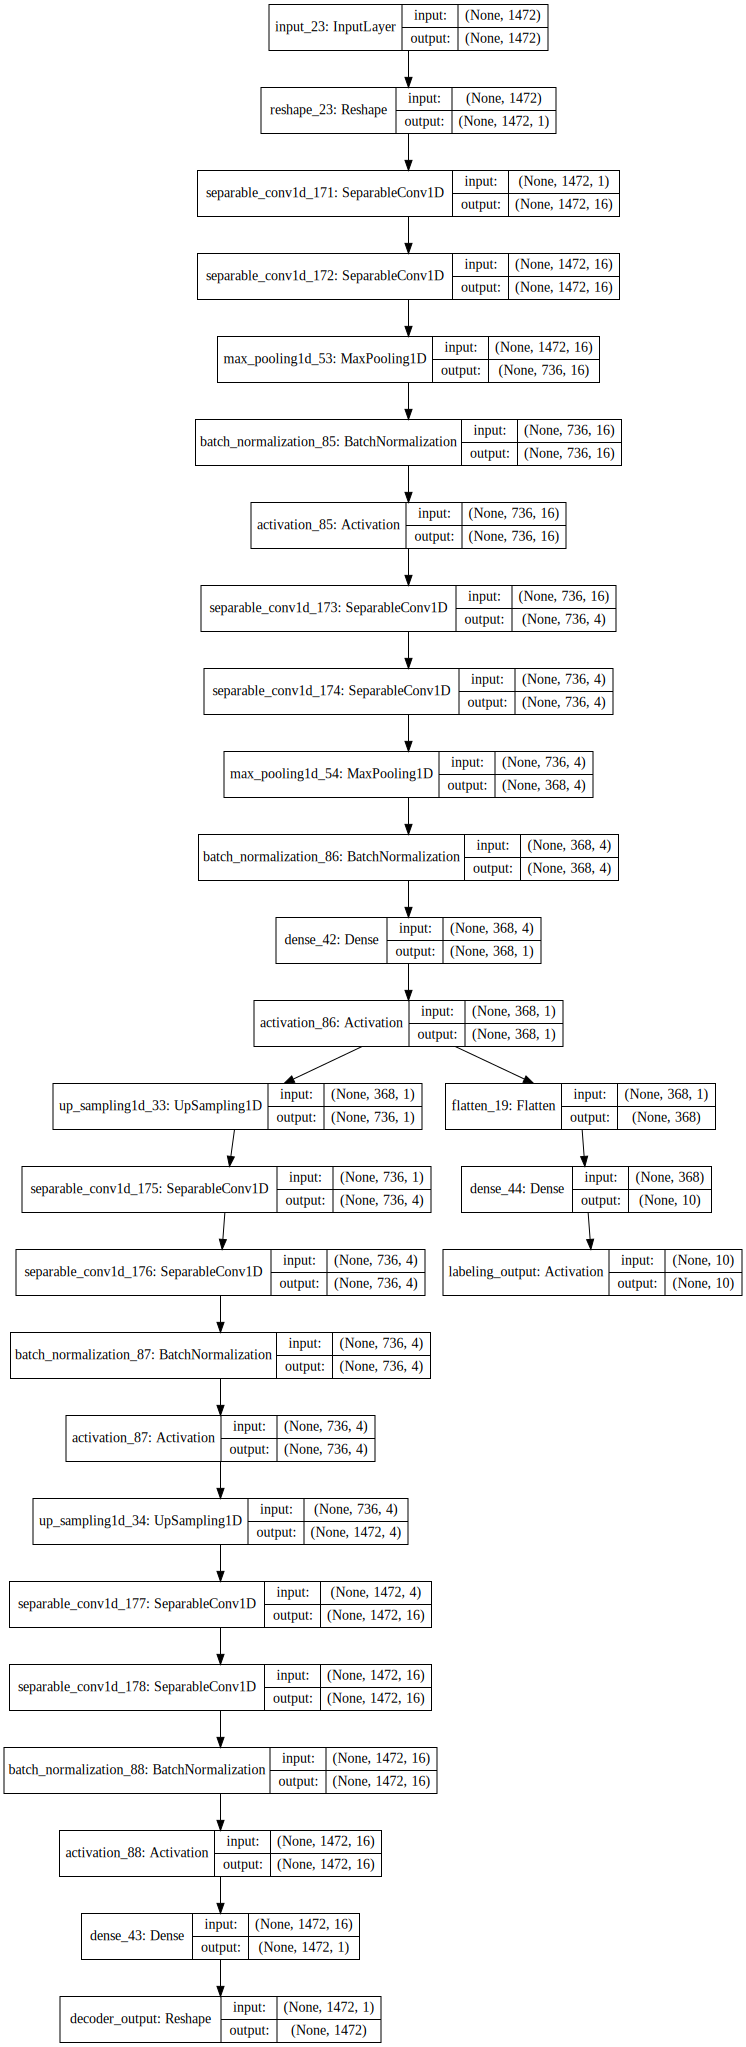

In [57]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
for i in range(100):
    model.fit(X_train,{"decoder_output":X_train,"labeling_output":y_train_encoded},epochs=100,verbose=False,batch_size=256)
    print(i)
    print(model.evaluate(X_train,{"decoder_output":X_train,"labeling_output":y_train_encoded}))

0
100/100 [==============================] - 1s 9ms/step
[0.8657148432731628, 0.9254508733749389, 1.7162669563293458]
1
100/100 [==============================] - 0s 219us/step
[0.906086401939392, 0.9401402473449707, 2.00981201171875]
2
100/100 [==============================] - 0s 239us/step
[1.174848346710205, 1.2086746454238892, 2.683423490524292]
3
100/100 [==============================] - 0s 225us/step
[1.048554491996765, 1.016022982597351, 2.8653722381591797]
4
100/100 [==============================] - 0s 219us/step
[0.9474284839630127, 0.8427211308479309, 3.1538762283325195]
5
100/100 [==============================] - 0s 229us/step
[1.0355913734436035, 0.8362816977500915, 4.083800983428955]
6
100/100 [==============================] - 0s 269us/step
[1.1353091597557068, 0.9210281467437744, 4.445379934310913]
7
100/100 [==============================] - 0s 219us/step
[1.2078813791275025, 1.032791395187378, 4.332878541946411]
8
100/100 [==============================] - 0s 229us

In [ ]:
y_predict = model.predict(X_train)[0]

import matplotlib.pyplot as plt
plt.plot(X_train[0,:],label="raw")
plt.plot(y_predict[0,:],label="predict")
plt.legend()
plt.show()

In [ ]:
l=[]
n=len(y_test)
y_predict=model.predict(X_test)[1]
for i in range(n):
    if np.argmax(y_predict,axis=1)[i] == y_test[i]:
        l.append(1)   
print(len(l)/float(n))

In [ ]:
l=[]
for i in range(10):
    clf=RandomForestClassifier(n_estimators=100)
    clf.fit(encoder.predict(X_train),y_train)
    l.append(clf.score(encoder.predict(X_test),y_test))
print(np.mean(l))

In [ ]:
l=[]
for i in range(10):
    clf=RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,y_train)
    l.append(clf.score(X_test,y_test))
print(np.mean(l))

# 